# Random Forest

In [142]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

In [143]:
# Read in the csv file
titanic_df = pd.read_csv(Path("data_files/titanic_cleaned.csv"))
titanic_df.head() # Reviewing dataframe

,passenger_id,pclass,survived,name,sex,age,sibsp,parch,fare,cabin,embarked,age_updated,embarked_updated,fare_updated,deck,pclass_updated
0,1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,211.3375,B5,S,29.0000,Southampton (UK),211.3375,B,First class
1,2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,151.5500,C22 C26,S,0.9167,Southampton (UK),151.5500,C,First class
2,3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,151.5500,C22 C26,S,2.0000,Southampton (UK),151.5500,C,First class
3,4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,151.5500,C22 C26,S,30.0000,Southampton (UK),151.5500,C,First class
4,5,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,151.5500,C22 C26,S,25.0000,Southampton (UK),151.5500,C,First class


In [144]:
# Create a copy of the dataframe
titanic = titanic_df.copy()

## Prepare the data

In [145]:
# Dropping columns as they have been updated
titanic = titanic.drop(['passenger_id', 'pclass', 'age', 'embarked', 'fare', 'cabin'], axis=1)
titanic.head()

,survived,name,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated
0,1,"Allen, Miss. Elisabeth Walton",female,0,0,29.0000,Southampton (UK),211.3375,B,First class
1,1,"Allison, Master. Hudson Trevor",male,1,2,0.9167,Southampton (UK),151.5500,C,First class
2,0,"Allison, Miss. Helen Loraine",female,1,2,2.0000,Southampton (UK),151.5500,C,First class
3,0,"Allison, Mr. Hudson Joshua Creighton",male,1,2,30.0000,Southampton (UK),151.5500,C,First class
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,1,2,25.0000,Southampton (UK),151.5500,C,First class


## Adding field that includes passenger title that has been extracted from name

In [146]:
# Getting the titles from the passenger names and assigning them to a new column
name_split = titanic['name'].str.split(',', expand=True)[1] # splitting name in two based on the ',' and taking the second column which contains the title
title = name_split.str.split('.', expand=True)[0] # splitting name in two based on the full stop and taking the first column that contains only the title
title = title.str.strip() # removing the additional space at the start of the title
titanic['title'] = title # adding title as a new column in the data frame

In [147]:
titanic['title'].value_counts(dropna=False)

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Dona              1
Capt              1
the Countess      1
Don               1
Jonkheer          1
Lady              1
Mme               1
Sir               1
Name: title, dtype: int64

In [148]:
# Creating a function to classify the titles into different groups
def title_grouped(title):
        if title == 'Miss' or title == 'Mlle' or title == 'Ms':
            return "Miss"
        elif title == 'Mrs' or title =='Mme':
            return "Mrs"
        elif title == "Mr" or title == 'Dr' or title == 'Rev':
            return "Mr"
        elif title == "Master":
            return "male_child"
        elif title == "Col" or title == "Major" or title == "Capt":
            return "Male_Military"
        elif title == "Don" or title == "Jonkheer" or title == "Sir":
            return "Female_Noblility"
        elif title == title == "the Countess" or title == "Lady" or title == "Dona":
            return "Noblility"
        else:
            return title
        
# Calling that function and assigning results to new column in dataframe
titanic['title_grouped'] = titanic['title'].apply(title_grouped)
titanic = titanic.drop(['title', 'name'], axis=1) # dropping the title and name columns as not required
titanic.head()


,survived,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated,title_grouped
0,1,female,0,0,29.0000,Southampton (UK),211.3375,B,First class,Miss
1,1,male,1,2,0.9167,Southampton (UK),151.5500,C,First class,male_child
2,0,female,1,2,2.0000,Southampton (UK),151.5500,C,First class,Miss
3,0,male,1,2,30.0000,Southampton (UK),151.5500,C,First class,Mr
4,0,female,1,2,25.0000,Southampton (UK),151.5500,C,First class,Mrs


In [149]:
titanic['title_grouped'].value_counts(dropna=False)

Mr                  773
Miss                264
Mrs                 198
male_child           61
Male_Military         7
Female_Noblility      3
Noblility             3
Name: title_grouped, dtype: int64

### Adding field that calculates the number of family members they were travelling with

In [150]:
# summing the number of travel companions
titanic['travel_companions'] = titanic['sibsp'] + titanic['parch']

# Dropping sibsp and parch columns as they are included in the new column
titanic = titanic.drop(['sibsp', 'parch'], axis=1) 

titanic.head()

,survived,sex,age_updated,embarked_updated,fare_updated,deck,pclass_updated,title_grouped,travel_companions
0,1,female,29.0000,Southampton (UK),211.3375,B,First class,Miss,0
1,1,male,0.9167,Southampton (UK),151.5500,C,First class,male_child,3
2,0,female,2.0000,Southampton (UK),151.5500,C,First class,Miss,3
3,0,male,30.0000,Southampton (UK),151.5500,C,First class,Mr,3
4,0,female,25.0000,Southampton (UK),151.5500,C,First class,Mrs,3


### Convert categorical data

In [151]:
# converting categorical using get_dummies and dropping the first column so the importance isn't inflated
sex_dummies = pd.get_dummies(titanic['sex'], drop_first=True) 
embarked_dummies = pd.get_dummies(titanic['embarked_updated'], drop_first=True)
deck_dummies = pd.get_dummies(titanic['deck'], drop_first=True)
pclass_dummies = pd.get_dummies(titanic['pclass_updated'], drop_first=True)
title_dummies = pd.get_dummies(titanic['title_grouped'], drop_first=True)

# Concatenate the encoded dummies with the data frame and drop uncessary columns
df_titanic_transformed = pd.concat([titanic, sex_dummies, embarked_dummies, deck_dummies, pclass_dummies, title_dummies], axis=1)

# dropping columns not required
df_titanic_transformed = df_titanic_transformed.drop(['sex', 'embarked_updated', 'deck', 'pclass_updated', 'title_grouped'], axis=1) 

df_titanic_transformed.head()

,survived,age_updated,fare_updated,travel_companions,male,Queenstown (IE),Southampton (UK),B,C,D,...,T,Unknown,Second class,Third class,Male_Military,Miss,Mr,Mrs,Noblility,male_child
0,1,29.0000,211.3375,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0.9167,151.5500,3,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,2.0000,151.5500,3,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,30.0000,151.5500,3,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,25.0000,151.5500,3,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0


### Separate the data into labels and features

In [152]:
# Separate the features (X) from the target (y)
# Define features set
X = df_titanic_transformed.copy()
X.drop("survived", axis=1, inplace=True)
X.head()

,age_updated,fare_updated,travel_companions,male,Queenstown (IE),Southampton (UK),B,C,D,E,...,T,Unknown,Second class,Third class,Male_Military,Miss,Mr,Mrs,Noblility,male_child
0,29.0000,211.3375,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.9167,151.5500,3,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.0000,151.5500,3,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,30.0000,151.5500,3,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,25.0000,151.5500,3,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [153]:
# Define target vector
y= df_titanic_transformed["survived"].ravel()
y[:5]

array([1, 1, 0, 0, 0], dtype=int64)

### Split data into training and testing datasets using train_test_split

In [154]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape


(981, 22)

## Apply random over sampler due to the imblanced data

In [155]:
# Instantiate the random oversample model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)


## Fitting the Random Forest Model

In [156]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [157]:
# Fitting the model
rf_model = rf_model.fit(X_train_ros, y_train_ros)

In [158]:
# Make predictions
predictions = rf_model.predict(X_test)

## Evaluate the models performance

In [159]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - perished', 'Acutal - survived'], columns=['Predicted - perished', 'Predicted - survived']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [160]:
# Define target vector
y= df_titanic_transformed["survived"].ravel()
y[:5]

array([1, 1, 0, 0, 0], dtype=int64)

In [161]:
# Displaying results
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"The accuracy score of the model is : {acc_score}")
print(f"")
print(f"")
print("Confusion Matrix")
display(cm_df)
print(f"")
print(f"")
print("Classification Report")
print(classification_report(y_test, predictions))

The balanced accuracy score of the model is 0.787960591133005
The accuracy score of the model is : 0.8079268292682927


Confusion Matrix


,Predicted - perished,Predicted - survived
Actual - perished,177,26
Acutal - survived,37,88




Classification Report
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       203
           1       0.77      0.70      0.74       125

    accuracy                           0.81       328
   macro avg       0.80      0.79      0.79       328
weighted avg       0.81      0.81      0.81       328



In [162]:
# Classification report
target_names = ["Perished", "Survived"]
print(classification_report(y_test, predictions, target_names=target_names))


              precision    recall  f1-score   support

    Perished       0.83      0.87      0.85       203
    Survived       0.77      0.70      0.74       125

    accuracy                           0.81       328
   macro avg       0.80      0.79      0.79       328
weighted avg       0.81      0.81      0.81       328



The model has a balanced accuracy score of 76% which is a result of the low recall score for predicting survivors.

Precision:
when the model predicts a survivor it correctly does so 79% of the time.  Indicating there are some survivors incorrectly being classified as not having survived.
When the model predicts someone who perished, it correctly do so 80% of the time.

Recall
This looks at when the passenger actually survived, how often the model correcly predicts them as surviving.  This model will classify a survivor correctly just 63% of the time.
When a passenger actually perished, the model will classify them correctly as perishing 90% of the time.

the model seems slightly more accurate at predicting those who perished than those who survived.

## Feature Importance

In [163]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.2403833274383998, 'fare_updated'),
 (0.2202201496113714, 'age_updated'),
 (0.13509091879301954, 'Mr'),
 (0.09570430437150595, 'male'),
 (0.08028426839098599, 'travel_companions'),
 (0.04268192064258377, 'Third class'),
 (0.035589289455121645, 'Unknown'),
 (0.03220300345230629, 'Miss'),
 (0.031212742910997925, 'Mrs'),
 (0.023864000860661084, 'Southampton (UK)'),
 (0.015491208138803043, 'Second class'),
 (0.008360701483091617, 'male_child'),
 (0.008195946155786487, 'Queenstown (IE)'),
 (0.007132273720113516, 'C'),
 (0.007088593398114106, 'B'),
 (0.005575997079826205, 'E'),
 (0.005164856622051662, 'D'),
 (0.0025043502326464848, 'F'),
 (0.002208416107277414, 'Male_Military'),
 (0.0007846176905104431, 'G'),
 (0.0002591134448256415, 'Noblility'),
 (0.0, 'T')]

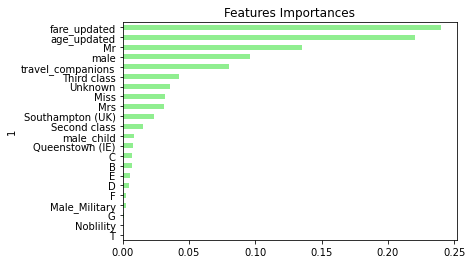

In [164]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)